# Notebook 1: Generating a Synthetic Evaluation Dataset

## 1. Introduction

Evaluating Retrieval-Augmented Generation (RAG) Agents is crucial for ensuring they provide accurate, relevant, and helpful responses. This notebook guides you through creating a high-quality synthetic evaluation dataset that will help you systematically benchmark and improve your RAG Agent. By generating high-quality synthetic datasets, we can:

1. Benchmark retrieval performance across different configurations
2. Identify blind spots in our system before deploying to users
3. Create reproducible evaluation workflows for continuous improvement

This notebook walks you through creating a synthetic dataset of queries, documents, and answers based on academic papers that will help you systematically evaluate and improve your RAG Agent.

## 2. Setup

First, let's install the necessary libraries and set up our environment:

In [ ]:
# Install required packages
%pip install openai llm-data-simulator chromadb sentence_transformers pandas matplotlib

In [ ]:
# Import libraries
import openai
from data_simulator import DataSimulator
import getpass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Display settings for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Define directories
DATA_DIR = "../data/papers"
EVAL_DIR = "../data/evalset"

## 3. Data Generation

We'll use OpenAI's API with the data_simulator library by langwatch to create our synthetic dataset. The library takes our source documents (in this case, the GPT-1 through GPT-4 papers from arXiv) and:

1. Filters out the noise to focus on quality content
2. Creates realistic questions researchers might actually ask
3. Generates accurate answers for each question

This saves us from manually creating hundreds of test examples while ensuring our evaluation is based on meaningful questions with reliable ground truth answers.

In [24]:
# Set up OpenAI API key
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
generator = DataSimulator(api_key=openai.api_key)

# Generate synthetic dataset
results = generator.generate_from_docs(
    file_paths=[f"{DATA_DIR}/gpt_1.pdf", f"{DATA_DIR}/gpt_2.pdf", f"{DATA_DIR}/gpt_3.pdf", f"{DATA_DIR}/gpt_4.pdf"],
    context="You're an AI research assistant helping researchers understand and analyze academic papers. The researchers need to find specific information, understand methodologies, compare approaches, and extract key findings from these papers.",
    example_queries="what are the main contributions of this paper\nwhat architecture is used in this paper\nexplain the significance of figure X in this paper"
)

Generating answers: 100%|██████████| 214/214 [06:38<00:00,  1.86s/it]


## 4. Data Analysis

Let's examine the generated questions manually first:

In [29]:
# Convert to DataFrame for easier analysis
eval_df = pd.DataFrame(results)

# Basic statistics
print(f"\nTotal number of questions: {len(eval_df)}")

# Display some example queries
print("\nExample queries:")
for i, query in enumerate(eval_df['query'].sample(5).values):
    print(f"{i+1}. {query}")


Total number of questions: 214

Example queries:
1. summarize the evaluation approach used for testing GPT-4 models
2. details on the evaluation methodology for few-shot learning in this study
3. compare the accuracy metrics across different model sizes for the HellaSwag and LAMBADA tasks
4. analysis of contamination effects on LAMBADA dataset performance
5. details on the evaluation conditions for GPT-3's in-context learning abilities


We can see that the queries are diverse and even look like real questions that a user might ask in production. Ideally, you would have real production data to provide as seed examples in the data_simulator library, but this is a good start. Now, let's evaluate the diversity of the generated questions. This is important because a varied dataset helps us test our RAG system's ability to handle different types of queries.

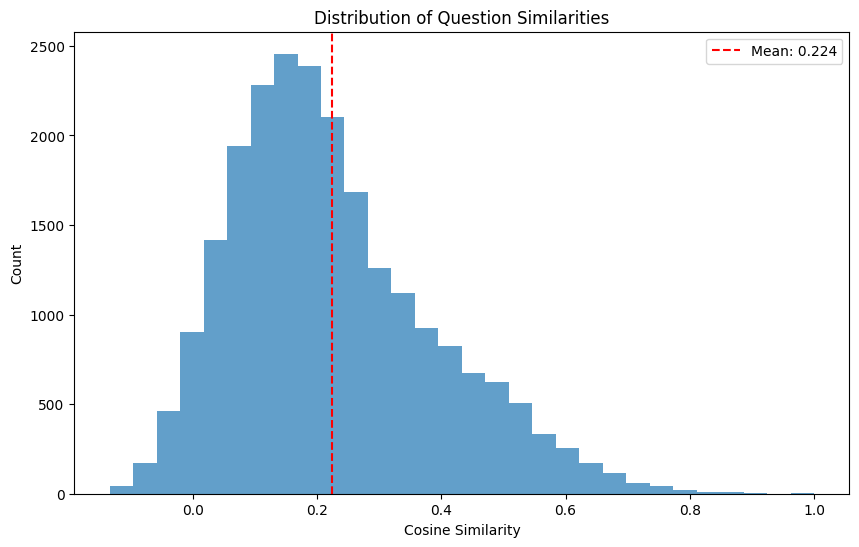

In [27]:
# Analyze semantic diversity using embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
eval_df['embedding'] = eval_df['query'].apply(lambda x: model.encode(x))

# Calculate pairwise similarities
embeddings = np.array(eval_df['embedding'].tolist())
similarities = cosine_similarity(embeddings)

# Get upper triangle values (excluding diagonal)
mask = np.triu_indices(len(similarities), k=1)
upper_tri_similarities = similarities[mask]

# Plot histogram of similarities
plt.figure(figsize=(10, 6))
plt.hist(upper_tri_similarities, bins=30, alpha=0.7)
plt.title('Distribution of Question Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.axvline(x=np.mean(upper_tri_similarities), color='r', linestyle='--', 
            label=f'Mean: {np.mean(upper_tri_similarities):.3f}')
plt.legend()
plt.show()

The histogram shows the distribution of pairwise similarities between our generated questions. A lower mean similarity indicates greater diversity:

- Mean < 0.3: Excellent diversity, questions cover many different topics and formats
- Mean 0.3-0.5: Good diversity, some question patterns may be repeated
- Mean > 0.5: Limited diversity, questions may be too similar

Our dataset shows a mean similarity of approximately 0.224, indicating excellent diversity in the generated questions. If the queries in your synthetic dataset are too similar, you may want to adjust the context or example queries to generate more diverse questions.

## 5. Save the Evaluation Set

Now that we've analyzed our dataset and confirmed its quality, let's save it for future use.

In [28]:
# Save the full evaluation dataset
eval_file = f"{EVAL_DIR}/evalset.json"
with open(eval_file, 'w') as f:
    json.dump(results, f, indent=2)

## 6. Next Steps

This synthetic dataset gives us a great starting point for evaluating our RAG Agent, but keep in mind that real-world usage is the ultimate test. While our generated queries help us establish a baseline, actual user interactions will reveal patterns and edge cases we might never anticipate. In the next notebook, we'll:

- Build a complete RAG Agent that can answer questions about our collection of GPT papers
- Implement a re-retrieval mechanism when initial results aren't sufficient
- Systematically evaluate the agent's performance using our synthetic dataset
- Establish a framework for continuous improvement based on evaluation results

This systematic approach not only helps us build a more robust RAG system from the start but also creates a foundation for ongoing refinement. The goal is to create an evaluation pipeline that evolves alongside your application, incorporating new user queries and feedback to ensure your RAG system keeps getting better over time. Remember that evaluation isn't a one-time task but an integral part of the RAG development lifecycle. The insights we gain from testing against our synthetic dataset will inform design decisions and highlight areas for improvement before we deploy to real users.